# Drug versus growth

## Content

1. Load modules
2. Import data
3. Match drug and growth data

## 1. Load modules

In [248]:
import os
import glob
import json
import re

import pandas as pd
import numpy as np
import math
import random 
from collections import Counter
from datetime import date
from datetime import datetime, timedelta
import itertools
from operator import itemgetter

import matplotlib.pyplot as plt
from matplotlib.cm import cool
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set(color_codes=True)
import plotly.express as px

from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

import fastcluster
from scipy import stats
from scipy.stats import kruskal
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import DBSCAN
from scipy.spatial import distance

import hdbscan
import umap

from statsmodels.stats.multitest import multipletests

In [249]:
scipy.__version__

NameError: name 'scipy' is not defined

In [2]:
# define date for saving figures
today = date.today().strftime("%Y-%m-%d") # for saving files
# set number of columns to show when display is called
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

## 2. Import data

In [3]:
# Set wd
os.chdir('/Users/clanc/OneDrive/Masterarbeit/analysis')

In [4]:
# Load info tables
screen_info = pd.read_csv('curated_input/screen_info.txt', \
                                   sep = ';', header = 0, index_col = 0)

strain_info = pd.read_csv('curated_input/strain_info.txt', \
                                   sep = ';', header = 0, index_col = 0)

strain_list = json.loads(open("curated_input/strain_list_untar.json").\
                                  read())

condition_list = json.loads(open("curated_input/drug_inkl_contr_list.json").\
                                  read())

In [5]:
# info on bad injections

bad_inject_info = pd.read_csv('intermed_results/01_noBadInjections/outliers.txt', \
                                   sep = ';', header = 0)

# outliers by strain
bad_inject_perS = [list(bad_inject_info.loc[bad_inject_info['strain'] == strain, 'injection']) for strain in strain_list]

In [6]:
d_metabo_FC_tab = pd.read_csv('replicate_drug_metabolsim/FC_table.csv', sep = ';', index_col = 0)

In [7]:
d_metabo_FDR_tab = pd.read_csv('replicate_drug_metabolsim/FDR_table.csv', sep = ';', index_col = 0)

In [8]:
d_metabo_PerC_tab = pd.read_csv('replicate_drug_metabolsim/Percent_table.csv', sep = ';', index_col = 0)

In [9]:
d_metabo_FC_tab_sig = pd.DataFrame(np.where(d_metabo_FDR_tab < 0.05, d_metabo_FC_tab, 1),\
                                   index = d_metabo_FC_tab.index, columns = d_metabo_FC_tab.columns)

In [10]:
d_metabo_FC_tab_sig = pd.DataFrame(np.where(d_metabo_FC_tab_sig < 1, d_metabo_FC_tab_sig, 1),\
                                   index = d_metabo_FC_tab_sig.index, columns = d_metabo_FC_tab_sig.columns)

In [11]:
d_metabo_PerC_tab_sig = pd.DataFrame(np.where(d_metabo_FDR_tab < 0.05, d_metabo_PerC_tab, 0),\
                                   index = d_metabo_PerC_tab.index, columns = d_metabo_PerC_tab.columns)

In [12]:
d_metabo_PerC_tab_sig = -1*d_metabo_PerC_tab_sig

In [13]:
d_metabo_PerC_tab_sig = pd.DataFrame(np.where(d_metabo_PerC_tab_sig < 0, d_metabo_PerC_tab_sig, 0),\
                                   index = d_metabo_PerC_tab.index, columns = d_metabo_PerC_tab.columns)

In [14]:
d_metabo_FC_tab_log = np.log2(d_metabo_FC_tab_sig)

In [15]:
d_metabo_FC_tab_log_unlab = d_metabo_FC_tab_log.copy()
d_metabo_PerC_tab_sig_unlab = d_metabo_PerC_tab_sig.copy()

In [16]:
d_metabo_FC_tab_sig[:10]

ABACAVIR SULFATE  ACEBUTOLOL  ACECAINIDE  ALFUZOSIN  ALMOTRIPTAN  \
S005               1.0         1.0         1.0    1.00000          1.0   
S006               1.0         1.0         1.0    1.00000          1.0   
S007               1.0         1.0         1.0    1.00000          1.0   
S008               1.0         1.0         1.0    1.00000          1.0   
S009               1.0         1.0         1.0    1.00000          1.0   
S010               1.0         1.0         1.0    1.00000          1.0   
S011               1.0         1.0         1.0    1.00000          1.0   
S012               1.0         1.0         1.0    1.00000          1.0   
S013               1.0         1.0         1.0    0.79054          1.0   
S014               1.0         1.0         1.0    1.00000          1.0   

      ALPRENOLOL  AMANTADINE  AMINOGLUTETHIMIDE  AMISULPRIDE  ANAGRELIDE  \
S005    1.000000    1.000000                1.0          1.0    1.000000   
S006    1.000000    1.000000                1.0          1.0    1.000000   
S007    1.000000    1.000000                1.0          1.0    1.000000   
S008    1.000000    1.000000                1.0          1.0    1.000000   
S009    1.000000    1.000000                1.0          1.0    1.000000   
S010    0.812777    1.000000                1.0          1.0    0.758775   
S011    1.000000    0.839832                1.0          1.0    0.764835   
S012    1.000000    1.000000                1.0          1.0    1.000000   
S013    1.000000    1.000000                1.0          1.0    0.744293   
S014    1.000000    1.000000                1.0          1.0    1.000000   

      ANASTROZOLE  ANTAZOLINE PHOSPHATE  APOMORPHINE   ARTEMISININ  ATENOLOL  \
S005     1.000000              1.000000          1.0  1.066439e-04       1.0   
S006     1.000000              1.000000          1.0  3.763398e-04       1.0   
S007     1.000000              1.000000          1.0  3.384504e-04       1.0   
S008     1.000000              1.000000          1.0  1.272496e-02       1.0   
S009     1.000000              1.000000          1.0  4.201645e-04       1.0   
S010     0.767977              1.000000          1.0  1.407433e-05       1.0   
S011     0.735593              0.857168          1.0  9.275379e-08       1.0   
S012     1.000000              1.000000          1.0  3.518792e-04       1.0   
S013     1.000000              1.000000          1.0  1.843985e-03       1.0   
S014     1.000000              1.000000          1.0  1.022966e-01       1.0   

      ATORVASTATIN CALCIUM  AZATADINE MALEATE  BAMBUTEROL  BENAZEPRIL  \
S005                   1.0                1.0         1.0    1.000000   
S006                   1.0                1.0         1.0    1.000000   
S007                   1.0                1.0         1.0    1.000000   
S008                   1.0                1.0         1.0    1.000000   
S009                   1.0                1.0         1.0    1.000000   
S010                   1.0                1.0         1.0    0.712719   
S011                   1.0                1.0         1.0    1.000000   
S012                   1.0                1.0         1.0    1.000000   
S013                   1.0                1.0         1.0    0.559365   
S014                   1.0                1.0         1.0    1.000000   

      BENZBROMARONE  BENZTHIAZIDE  BETAMETHASONE ACETATE  \
S005            1.0      1.000000                    1.0   
S006            1.0      1.000000                    1.0   
S007            1.0      1.000000                    1.0   
S008            1.0      1.000000                    1.0   
S009            1.0      1.000000                    1.0   
S010            1.0      0.727307                    1.0   
S011            1.0      0.727484                    1.0   
S012            1.0      1.000000                    1.0   
S013            1.0      1.000000                    1.0   
S014            1.0      1.000000                    1.0   

      BE

Get lables and phylogeny info

In [46]:
phyla = list(strain_info.loc[:,"phylum"].unique())
genus = list(strain_info.loc[:,"genus"].unique())


In [47]:
lut_phyl = dict(zip(phyla, sns.hls_palette(len(phyla))))
lut_genus = dict(zip(phyla, sns.hls_palette(len(genus))))

In [40]:
d_metabo_FC_tab_log_phyl_list = pd.Series([strain_info.loc[s, "phylum"] for \
                                           s in d_metabo_FC_tab_log.index]).map(lut_phyl)
d_metabo_PerC_tab_sig_phyl_list = pd.Series([strain_info.loc[s, "phylum"] for \
                                             s in d_metabo_PerC_tab_sig.index]).map(lut_phyl)

d_metabo_FC_tab_log_red_phyl_list = pd.Series([strain_info.loc[s, "phylum"] for \
                                               s in d_metabo_FC_tab_log_red.index]).map(lut_phyl)
d_metabo_PerC_tab_sig_red_phyl_list = pd.Series([strain_info.loc[s, "phylum"] for \
                                                 s in d_metabo_PerC_tab_sig_red.index]).map(lut_phyl)

s_by_d_matrix_any_red_phyl_list = pd.Series([strain_info.loc[s, "phylum"] for \
                                             s in s_by_d_matrix_any_red.index]).map(lut_phyl)
s_by_d_matrix_contr_red_phyl_list = pd.Series([strain_info.loc[s, "phylum"] for \
                                               s in s_by_d_matrix_contr_red.index]).map(lut_phyl)

dist_any_norm_df_red_phyl_list = pd.Series([strain_info.loc[s, "phylum"] for \
                                            s in dist_any_norm_df_red.index]).map(lut_phyl)
dist_contr_norm_df_red_phyl_list = pd.Series([strain_info.loc[s, "phylum"] for \
                                              s in dist_contr_norm_df_red.index]).map(lut_phyl)

In [41]:
d_metabo_FC_tab_log.index = [strain_info.loc[s, 'phylum'][:6] + '_' +\
                          strain_info.loc[s, 'genus'][:6] + '_' +\
                          strain_info.loc[s, 'species'][:6] for s in  d_metabo_FC_tab_log.index]

In [42]:
d_metabo_PerC_tab_sig.index = [strain_info.loc[s, 'phylum'][:6] + '_' +\
                          strain_info.loc[s, 'genus'][:6] + '_' +\
                          strain_info.loc[s, 'species'][:6] for s in  d_metabo_PerC_tab_sig.index]

In [43]:
d_metabo_FC_tab_log_red.index = [strain_info.loc[s, 'phylum'][:6] + '_' +\
                          strain_info.loc[s, 'genus'][:6] + '_' +\
                          strain_info.loc[s, 'species'][:6] for s in  d_metabo_FC_tab_log_red.index]

In [44]:
d_metabo_PerC_tab_sig_red.index = [strain_info.loc[s, 'phylum'][:6] + '_' +\
                          strain_info.loc[s, 'genus'][:6] + '_' +\
                          strain_info.loc[s, 'species'][:6] for s in  d_metabo_PerC_tab_sig_red.index]

In [45]:
s_by_d_matrix_any_red.index = [strain_info.loc[s, 'phylum'][:6] + '_' +\
                             strain_info.loc[s, 'genus'][:6] + '_' +\
                             strain_info.loc[s, 'species'][:6] for s in  s_by_d_matrix_any_red.index]

In [46]:
s_by_d_matrix_contr_red.index = [strain_info.loc[s, 'phylum'][:6] + '_' +\
                             strain_info.loc[s, 'genus'][:6] + '_' +\
                             strain_info.loc[s, 'species'][:6] for s in  s_by_d_matrix_contr_red.index]

In [47]:
dist_any_norm_df_red.index = [strain_info.loc[s, 'phylum'][:6] + '_' +\
                             strain_info.loc[s, 'genus'][:6] + '_' +\
                             strain_info.loc[s, 'species'][:6] for s in  dist_any_norm_df_red.index]

In [48]:
dist_contr_norm_df_red.index = [strain_info.loc[s, 'phylum'][:6] + '_' +\
                             strain_info.loc[s, 'genus'][:6] + '_' +\
                             strain_info.loc[s, 'species'][:6] for s in  dist_contr_norm_df_red.index]

<Figure size 432x288 with 0 Axes>

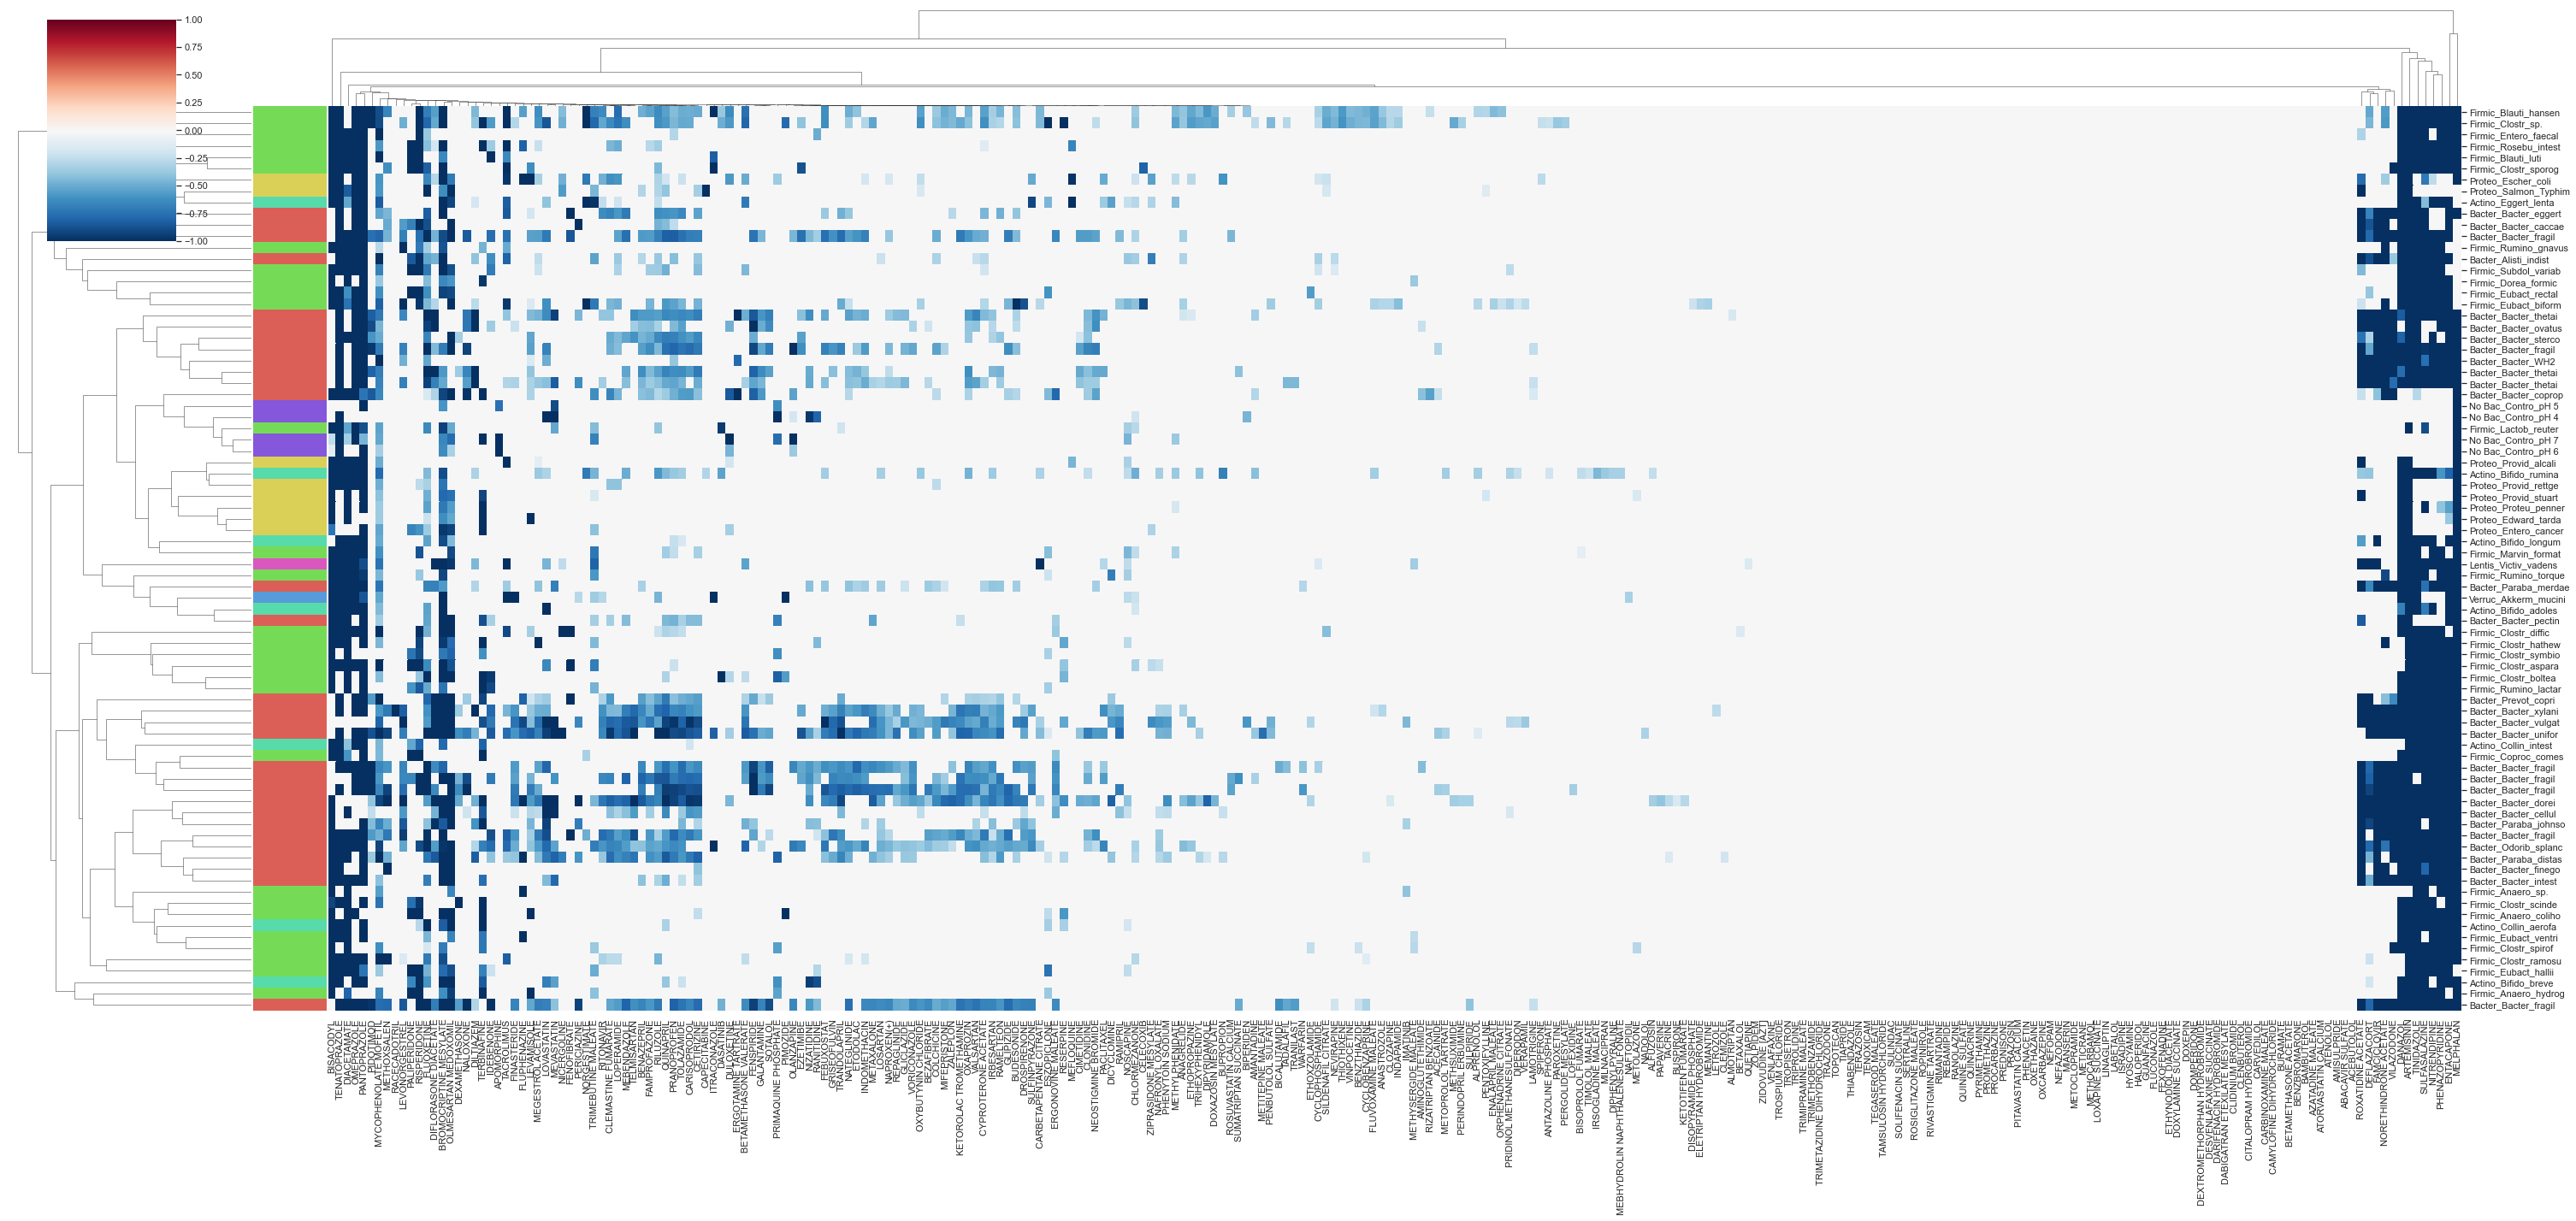

In [381]:
plt.figure()

g_FC_raw = sns.clustermap(d_metabo_FC_tab_log, cmap="RdBu_r", row_colors = list(d_metabo_FC_tab_log_phyl_list),\
                          center = 0, vmin = -1, vmax = 1, dendrogram_ratio=0.1,\
                          figsize=(42,20), yticklabels=True,
                          xticklabels=True, annot_kws={"size": 3})

#plt.savefig('intermed_results/11_filtering_dist_to_cont/'+\
#        today+'_d_metabo_FC_cmap_FDR0.05.pdf',\
#        bbox_inches='tight')


plt.show()

<Figure size 432x288 with 0 Axes>

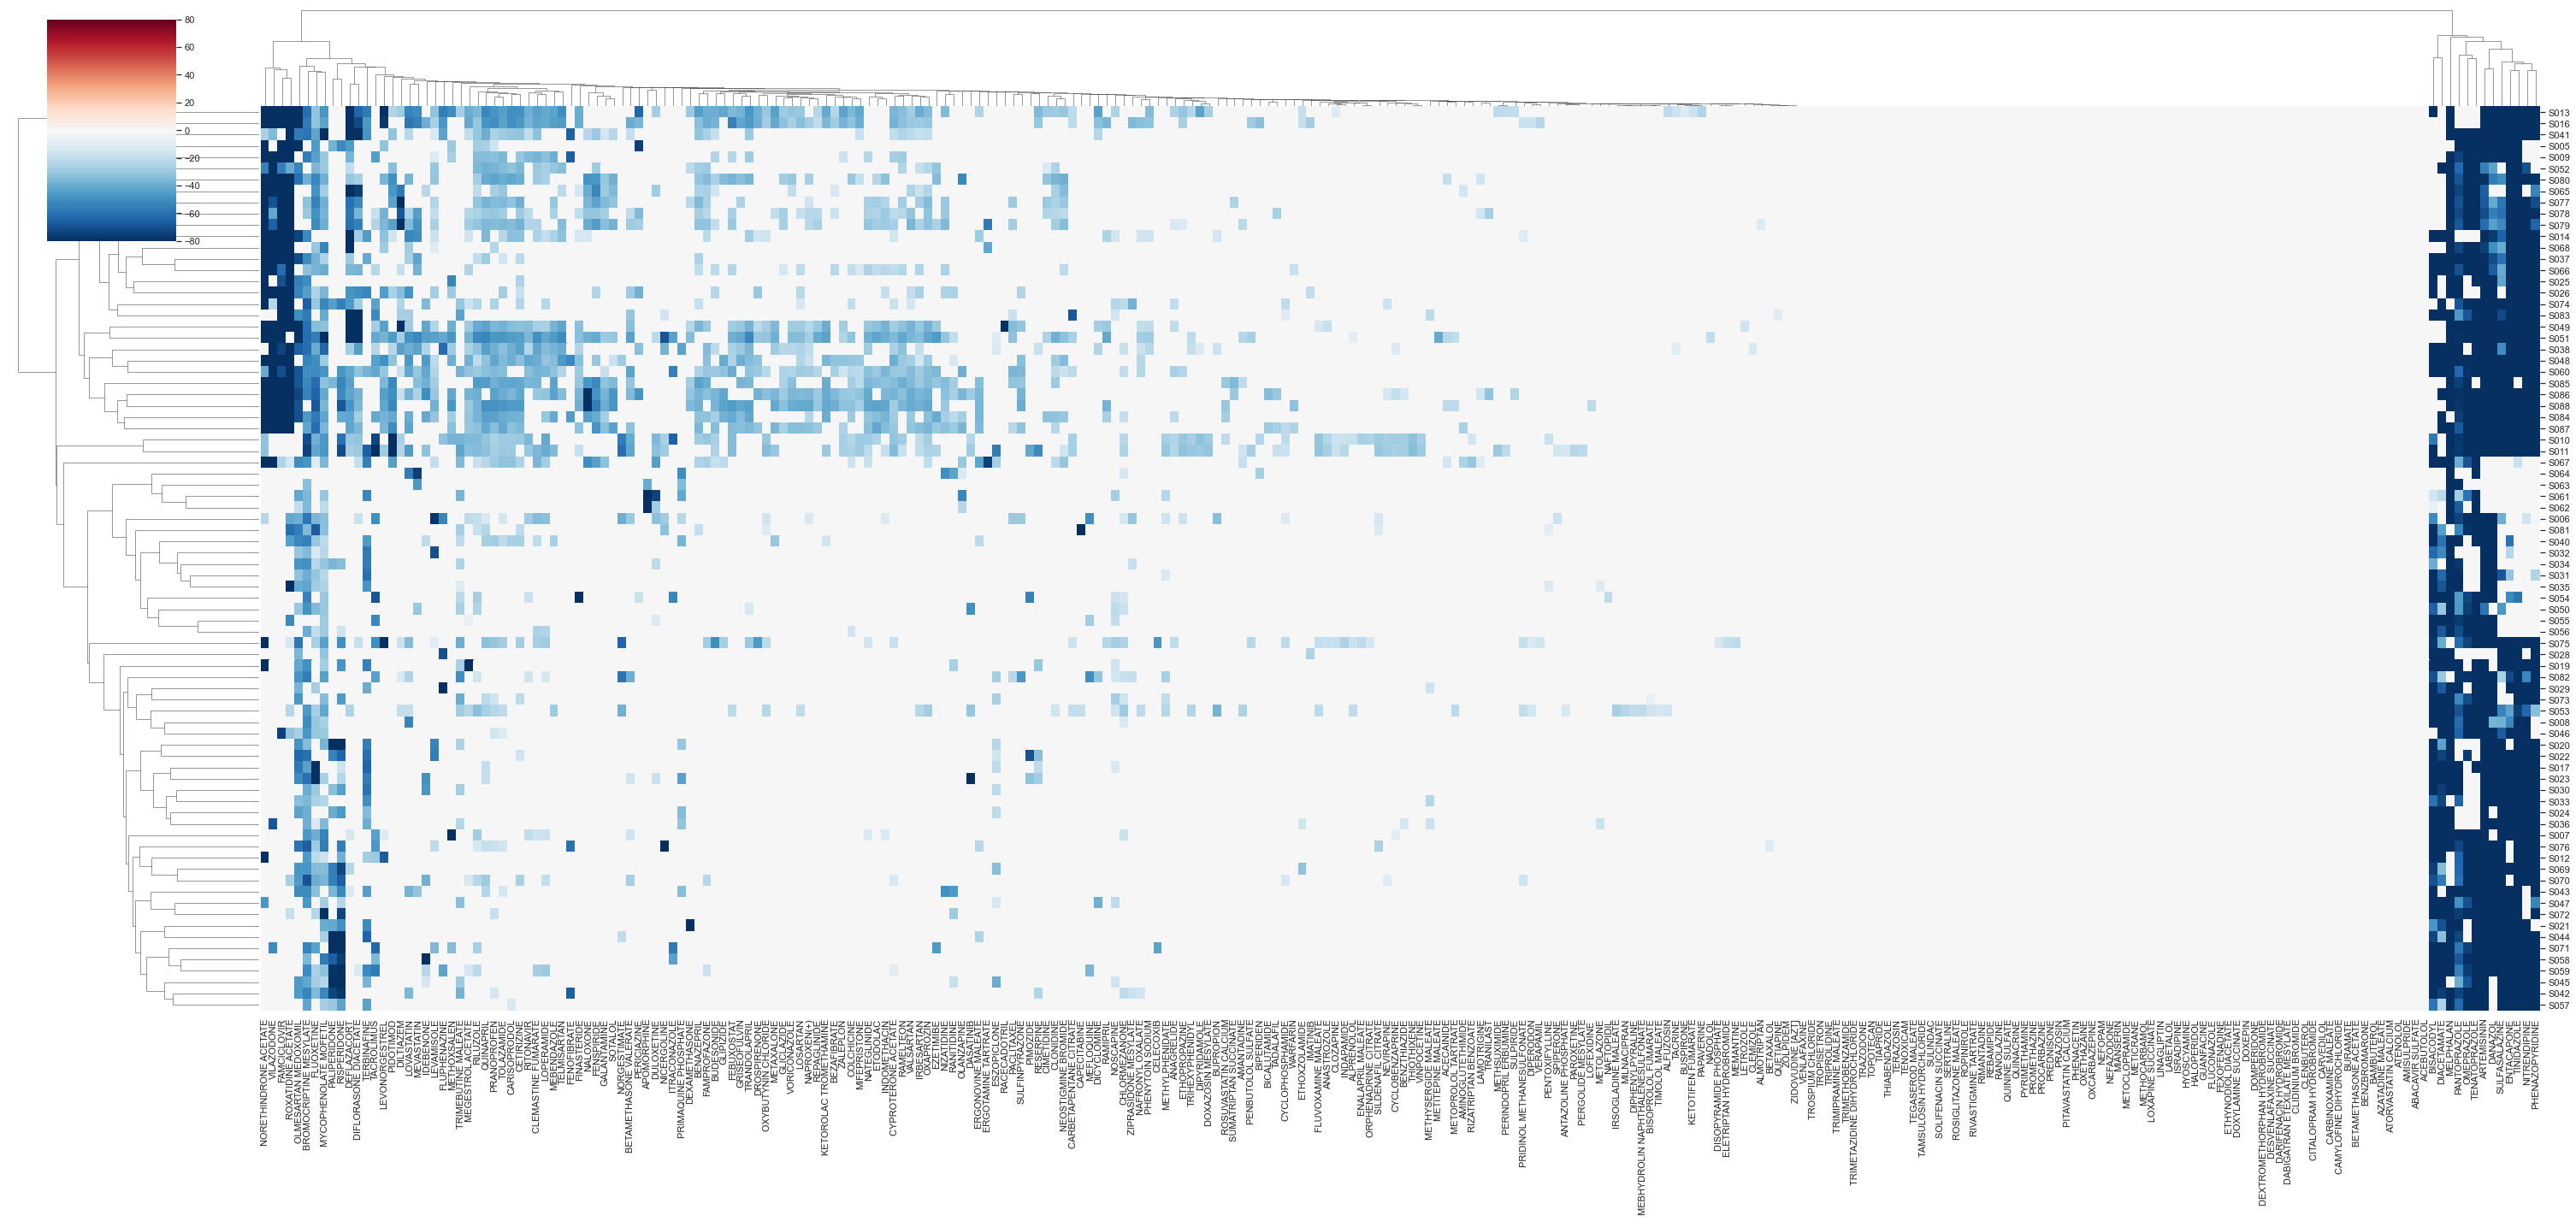

In [17]:
plt.figure()

g_PerC_raw = sns.clustermap(d_metabo_PerC_tab_sig, cmap="RdBu_r", #row_colors = list(d_metabo_PerC_tab_sig_phyl_list),\
                            center = 0, vmin = -80, vmax = 80, dendrogram_ratio=0.1,\
                            figsize=(42,20), yticklabels=True,
                            xticklabels=True, annot_kws={"size": 3})

#plt.savefig('intermed_results/11_filtering_dist_to_cont/'+\
#        today+'_d_metabo_PerC_cmap_FDR0.05.pdf',\
#        bbox_inches='tight')


plt.show()

### Load growth data

In [18]:
growth_Pval_ref = pd.read_csv('../data_sources/Maier_2018/pVals_drug_impact_on_growth.csv', sep=';')

In [19]:
strain_match_table = pd.read_csv('../data_sources/Maier_2018/strain_matching.csv', sep=';')

In [20]:
strain_match_table['drug_impact_ID'].count()

26

In [21]:
# Get NT identifiers for matching
NT_idents = strain_match_table.loc[pd.notnull(strain_match_table['drug_impact_ID']), 'NT data base']

In [22]:
# set index column
growth_Pval_ref_study_strains = growth_Pval_ref
growth_Pval_ref_study_strains.index = growth_Pval_ref['chemical_name']


In [23]:
# reduce to matching strains
col_names = growth_Pval_ref_study_strains.columns

growth_Pval_ref_study_strains = growth_Pval_ref_study_strains.\
loc[:, [name for name in col_names if any(NT in name for NT in NT_idents)]]

In [24]:
# Convert strain names to S0XX IDs
NT_S0XX_dict = dict(zip(strain_match_table['NT data base'], strain_match_table['drug_impact_ID']))

names_conv = []

for s_name in growth_Pval_ref_study_strains.columns:
    
    p = re.compile('(NT\d{4})')
    result = p.search(s_name)
    NT_ident = result.group(0)
    
    names_conv.append(NT_S0XX_dict[NT_ident])

In [25]:
growth_Pval_ref_study_strains.columns = names_conv

In [26]:
list(screen_info['name'])

['Abacavir',
 'Acebutolol',
 'Acecainide',
 'Alfuzosin',
 'Almotriptan',
 'Alprenolol',
 'Amantadine',
 'Aminoglutethimide',
 'Amisulpride',
 'Anagrelide',
 'Anastrozole',
 'Antazoline',
 'Apomorphine',
 'CHEMBL269671',
 'Atenolol',
 'CHEMBL3039114',
 'Azatadine',
 'Bambuterol',
 'Benazepril',
 'Benzbromarone',
 'Benzthiazide',
 'SCHEMBL1116231',
 'CHEMBL3186310',
 'Betaxolol',
 'Bezafibrate',
 'Bicalutamide',
 'Biperiden',
 'Bisacodyl',
 'Bisoprolol',
 'CHEMBL3039313',
 'CHEMBL3039455',
 'Bupropion',
 'Buramate',
 'Buspirone',
 'Camylofin',
 'SCHEMBL2184815',
 'Pentoxyverine',
 'Carbinoxamine',
 'Carisoprodol',
 'Carvedilol',
 'Celecoxib',
 'Cetirizine',
 'Chlormezanone',
 'Cimetidine',
 'Citalopram',
 'Clemastine',
 'Clemizole',
 'Planipart',
 'Clidinium',
 'Clonidine',
 'Clopidogrel',
 'Clozapine',
 'Colchicine',
 'Cyclobenzaprine',
 'Cyclophosphamide',
 'CHEMBL64990',
 'Dabigatran etexilate',
 'CHEMBL3039355',
 'SCHEMBL113331',
 'Dasatinib',
 'CHEMBL3182644',
 'Desvenlafaxine',
 'C

In [27]:
# reduce to matching drugs
#----------

# fix incomplete matches
screen_d_names = ['ATENOLOL', 'CYCLOBENZAPRINE', 'TACRINE', 'NAPROXEN(+)']
maier_d_names = ['(R)-(+)-Atenolol', 'Cyclobenzaprine hydrochloride', 'Tacrine hydrochloride', 'Naproxen']
maier_screen_dict = dict(zip(maier_d_names, screen_d_names))

In [28]:
# search for substring in maier data
[d_name for d_name in growth_Pval_ref_study_strains.index if 'naprox' in d_name.lower()]

['Naproxen', '(R) -Naproxen sodium salt']

In [29]:
# Check entries in screen data
screen_info.loc[['NAPROXEN(+)'],:]

TherapeuticIndication  TargetedRT  TargetedMZ  \
MOLENAME                                                                        
NAPROXEN(+)  antiinflammatory, analgesic, antipyretic         4.1  230.094295   

            DrugPoolNumbers  EstimatedColonConcentrationMaier2018uM  \
MOLENAME                                                              
NAPROXEN(+)  11  13  15  17                                     NaN   

                                      SMILES              STATUS TradeName  \
MOLENAME                                                                     
NAPROXEN(+)  COc1ccc2cc(C(C)C(=O)[O-])ccc2c1  USP, INN, BAN, JAN     ALEVE   

                    cas iupacName     molArea  molCACO2 molFormula  \
MOLENAME                                                             
NAPROXEN(+)  22204-53-1       NaN  255.756512     -4.73   C14H13O3   

             molHALFLIFE  molHERG  molLD50   molLogP   molLogS  molPAINS  \
MOLENAME                                                                   
NAPROXEN(+)         1.52      0.0   659.33  3.227074 -3.646627      0.01   

             molPAMPA  molPGPINHIB  molPGPSUBST     molPSA   molVolume  \
MOLENAME                                                                 
NAPROXEN(+)     -4.46          0.0         0.02  35.918762  224.724726   

              molWeight      name  ref salt_name salt_smiles  \
MOLENAME                                                       
NAPROXEN(+)  229.086469  Naproxen  NaN       NaN         NaN   

                                          smiles              source  \
MOLENAME                                                               
NAPROXEN(+)  C[C@H](C([O-])=O)c1ccc2cc(ccc2c1)OC  synthetic; RS-3650   

             Number_of_aliphatic_carboxylic_acids  \
MOLENAME                                            
NAPROXEN(+)                                     1   

             Number_of_aliphatic_hydroxyl_groups  \
MOLENAME                                           
NAPROXEN(+)                                    0   

             Number_of_aliphatic_hydroxyl_groups_excluding_tert_OH  \
MOLENAME                                                             
NAPROXEN(+)                                                  0       

             Number_of_N_functional_groups_attached_to_aromatics  \
MOLENAME                                                           
NAPROXEN(+)                                                  0     

             Number_of_Aromatic_carboxylic_acide  \
MOLENAME                                           
NAPROXEN(+)                                    0   

             Number_of_aromatic_nitrogens  Number_of_aromatic_amines  \
MOLENAME                                                               
NAPROXEN(+)                             0                          0   

             Number_of_aromatic_hydroxyl_groups  Number_of_carboxylic_acids  \
MOLENAME                                                                      
NAPROXEN(+)                                   0                           1   

             Number_of_carboxylic_acids2  Number_of_carbonyl_O  \
MOLENAME                                                         
NAPROXEN(+)                            1                     1   

             Number_of_carbonyl_O__excluding_COOH  Number_of_thiocarbonyl  \
MOLENAME                                                                    
NAPROXEN(+)                                     1                       0   

             Number_of_C_OH_CCN_Ctert_alkyl_or_C_OH_CCNcyclic  \
MOLENAME                                                        
NAPROXEN(+)                                                 0   

             Number_of_Imines  Number_of_Tertiary_amines  \
MOLENAME                                                   
NAPROXEN(+)                 0                          0   

             Number_of_Secondary_amines  Number_of_Primary_amines  \
MOLENAME                                    

In [30]:
# convert maier indices to drug screen info
growth_Pval_ref_study_strains = growth_Pval_ref_study_strains.rename(index=maier_screen_dict)

In [31]:
# matching names of screen info
d_lower_list = [s.lower() for s in screen_info.index]

In [32]:
matched_names = [d_name for d_name in growth_Pval_ref_study_strains.index if d_name.lower() in d_lower_list]

growth_Pval_ref_study_strains = growth_Pval_ref_study_strains.loc[matched_names, :]

growth_Pval_ref_study_strains.index = [s.upper() for s in matched_names]


In [33]:
growth_Pval_ref_study_strains = growth_Pval_ref_study_strains.transpose()

In [34]:
# remvoe S088
no88_strain_list = [s for s in growth_Pval_ref_study_strains.index if s != 'S088']

In [35]:
growth_Pval_ref_study_strains = growth_Pval_ref_study_strains.loc[no88_strain_list, :]

In [36]:
#remove digoxin
noDig_drug_list = [col for col in growth_Pval_ref_study_strains.columns if not(col == 'DIGOXIN')]

In [37]:
growth_Pval_ref_study_strains = growth_Pval_ref_study_strains.loc[:,noDig_drug_list]

In [38]:
growth_Pval_ref_study_strains_unlab = growth_Pval_ref_study_strains.copy()

In [41]:
growth_Pval_ref_study_strains_unlab

TINIDAZOLE  BENZBROMARONE   OXETHAZAINE  PYRIMETHAMINE  ENTACAPONE  \
S054  6.511430e-04       0.965779  1.000000e+00   8.642180e-04    1.000000   
S005  5.038340e-06       0.015110  1.343440e-02   1.861650e-05    0.659620   
S048  2.605180e-05       0.002626  1.041153e-02   4.356230e-05    0.457338   
S065  5.038340e-06       0.001233  1.156917e-02   5.038340e-06    1.000000   
S077  1.428640e-05       0.000323  1.797486e-03   1.744030e-05    0.106586   
S051  1.315840e-06       0.007823  8.061090e-04   5.325670e-04    0.038217   
S016  2.330080e-06       0.002264  1.210380e-05   1.127486e-03    0.006753   
S049  2.062160e-05       0.067694  1.467225e-03   5.514780e-07    0.382252   
S008  6.308312e-01       0.004147  9.199307e-02   5.038340e-06    1.000000   
S046  5.038340e-06       0.057591  1.338190e-05   5.038340e-06    1.000000   
S023  8.232370e-06       0.000082  9.036043e-02   4.374242e-03    0.000007   
S076  5.063860e-06       0.000031  7.629586e-02   5.137176e-01    0.258503   
S007  6.890440e-06       0.000045  2.987860e-05   8.870840e-05    1.000000   
S017  3.198770e-07       0.004132  3.142310e-07   5.257922e-01    0.009153   
S044  8.662560e-06       0.000760  5.038340e-06   3.461375e-01    0.000207   
S033  5.265290e-06       0.018524  1.975430e-05   7.866804e-01    0.000021   
S082  4.103190e-05       0.021454  2.226353e-02   4.328366e-03    1.000000   
S069  9.673280e-04       0.003863  1.666530e-04   2.168721e-03    0.085123   
S060  8.570330e-06       0.000010  1.413695e-01   6.914110e-06    0.154234   
S038  4.865600e-06       0.000005  1.034560e-05   7.477500e-02    0.894442   
S066  4.929710e-07       0.000059  3.272305e-02   5.017709e-01    0.846882   
S041  4.646640e-05       0.002185  6.790140e-05   6.588609e-01    0.029621   
S059  6.048970e-04       0.006441  1.945500e-04   4.751745e-01    0.012478   
S012  5.038340e-06       0.000023  1.165360e-05   7.570777e-02    0.022567   
S047  1.973290e-06       0.183315  6.070660e-06   9.256617e-01    0.000008   

      LOXAPINE SUCCINATE  PIMOZIDE  OMEPRAZOLE  TELMISARTAN  CYCLOBENZAPRINE  \
S054        1.323349e-01  0.867820    1.000000     1.000000         0.001347   
S005        9.326402e-02  0.974608    1.000000     0.867891         0.080397   
S048        2.360803e-02  0.013735    1.000000     0.241735         0.029899   
S065        3.157443e-03  0.961686    0.889879     1.000000         0.118261   
S077        6.129070e-04  0.251410    1.000000     0.224460         0.056079   
S051        4.918900e-05  0.002356    1.000000     0.316193         0.004347   
S016        2.356770e-06  0.001704    1.000000     0.118427         0.005980   
S049        1.000000e+00  1.000000    1.000000     0.783148         0.790284   
S008        8.352546e-01  0.876064    0.239610     1.000000         0.038059   
S046        8.653843e-01  0.735080    0.793318     1.000000         0.101354   
S023        8.735882e-01  1.000000    1.000000     0.907487         0.827580   
S076        7.657636e-01  0.111000    1.000000     0.000016         0.133709   
S007        5.158943e-01  0.583015    0.945027     0.262007         0.734539   
S017        1.000000e+00  0.965695    0.540771     1.000000         0.017138   
S044        1.000000e+00  1.000000    0.018435     0.027280         0.835255   
S033        7.362280e-01  0.743921    0.000013     1.000000         0.258175   
S082        5.485878e-01  0.100398    0.984316     0.502534         0.180636   
S069        6.068250e-02  0.000219    0.006472     0.131258         0.140198   
S060        9.542510e-05  0.960000    0.970445     1.000000         0.135224   
S038        5.038340e-06  0.009098    0.465619     0.004468         0.266490   
S066        4.929710e-07  0.088349    0.586042     0.116134         0.341630   
S041        3.860705e-01  0.004271    0.860768     0.244603         0.213623   
S059        1.000000e+00  0.001273    0.000750     0.011829         1.000000   
S012        8.862672e-01  0.042896    0.461567     0.718156

## 3. Match drug and growth data

In [39]:
d_metabo_FC_tab_log_red_maier = d_metabo_FC_tab_log_unlab.loc[growth_Pval_ref_study_strains.index,\
                                                              growth_Pval_ref_study_strains.columns]

In [40]:
d_metabo_PerC_tab_sig_red_maier = d_metabo_PerC_tab_sig_unlab.loc[growth_Pval_ref_study_strains.index,\
                                                          growth_Pval_ref_study_strains.columns]

In [48]:
growth_Pval_phyl_list = pd.Series([strain_info.loc[s, "phylum"] for \
                                            s in growth_Pval_ref_study_strains.index]).map(lut_phyl)

In [49]:
growth_Pval_ref_study_strains.index = [strain_info.loc[s, 'phylum'][:6] + '_' +\
                             strain_info.loc[s, 'genus'][:6] + '_' +\
                             strain_info.loc[s, 'species'][:6] for s in  growth_Pval_ref_study_strains.index]

In [50]:
growth_Pval_ref_study_strains_log = -1*np.log10(growth_Pval_ref_study_strains)

In [51]:
growth_Pval_ref_study_strains_log = growth_Pval_ref_study_strains_log.replace(np.nan, 0)

<Figure size 432x288 with 0 Axes>

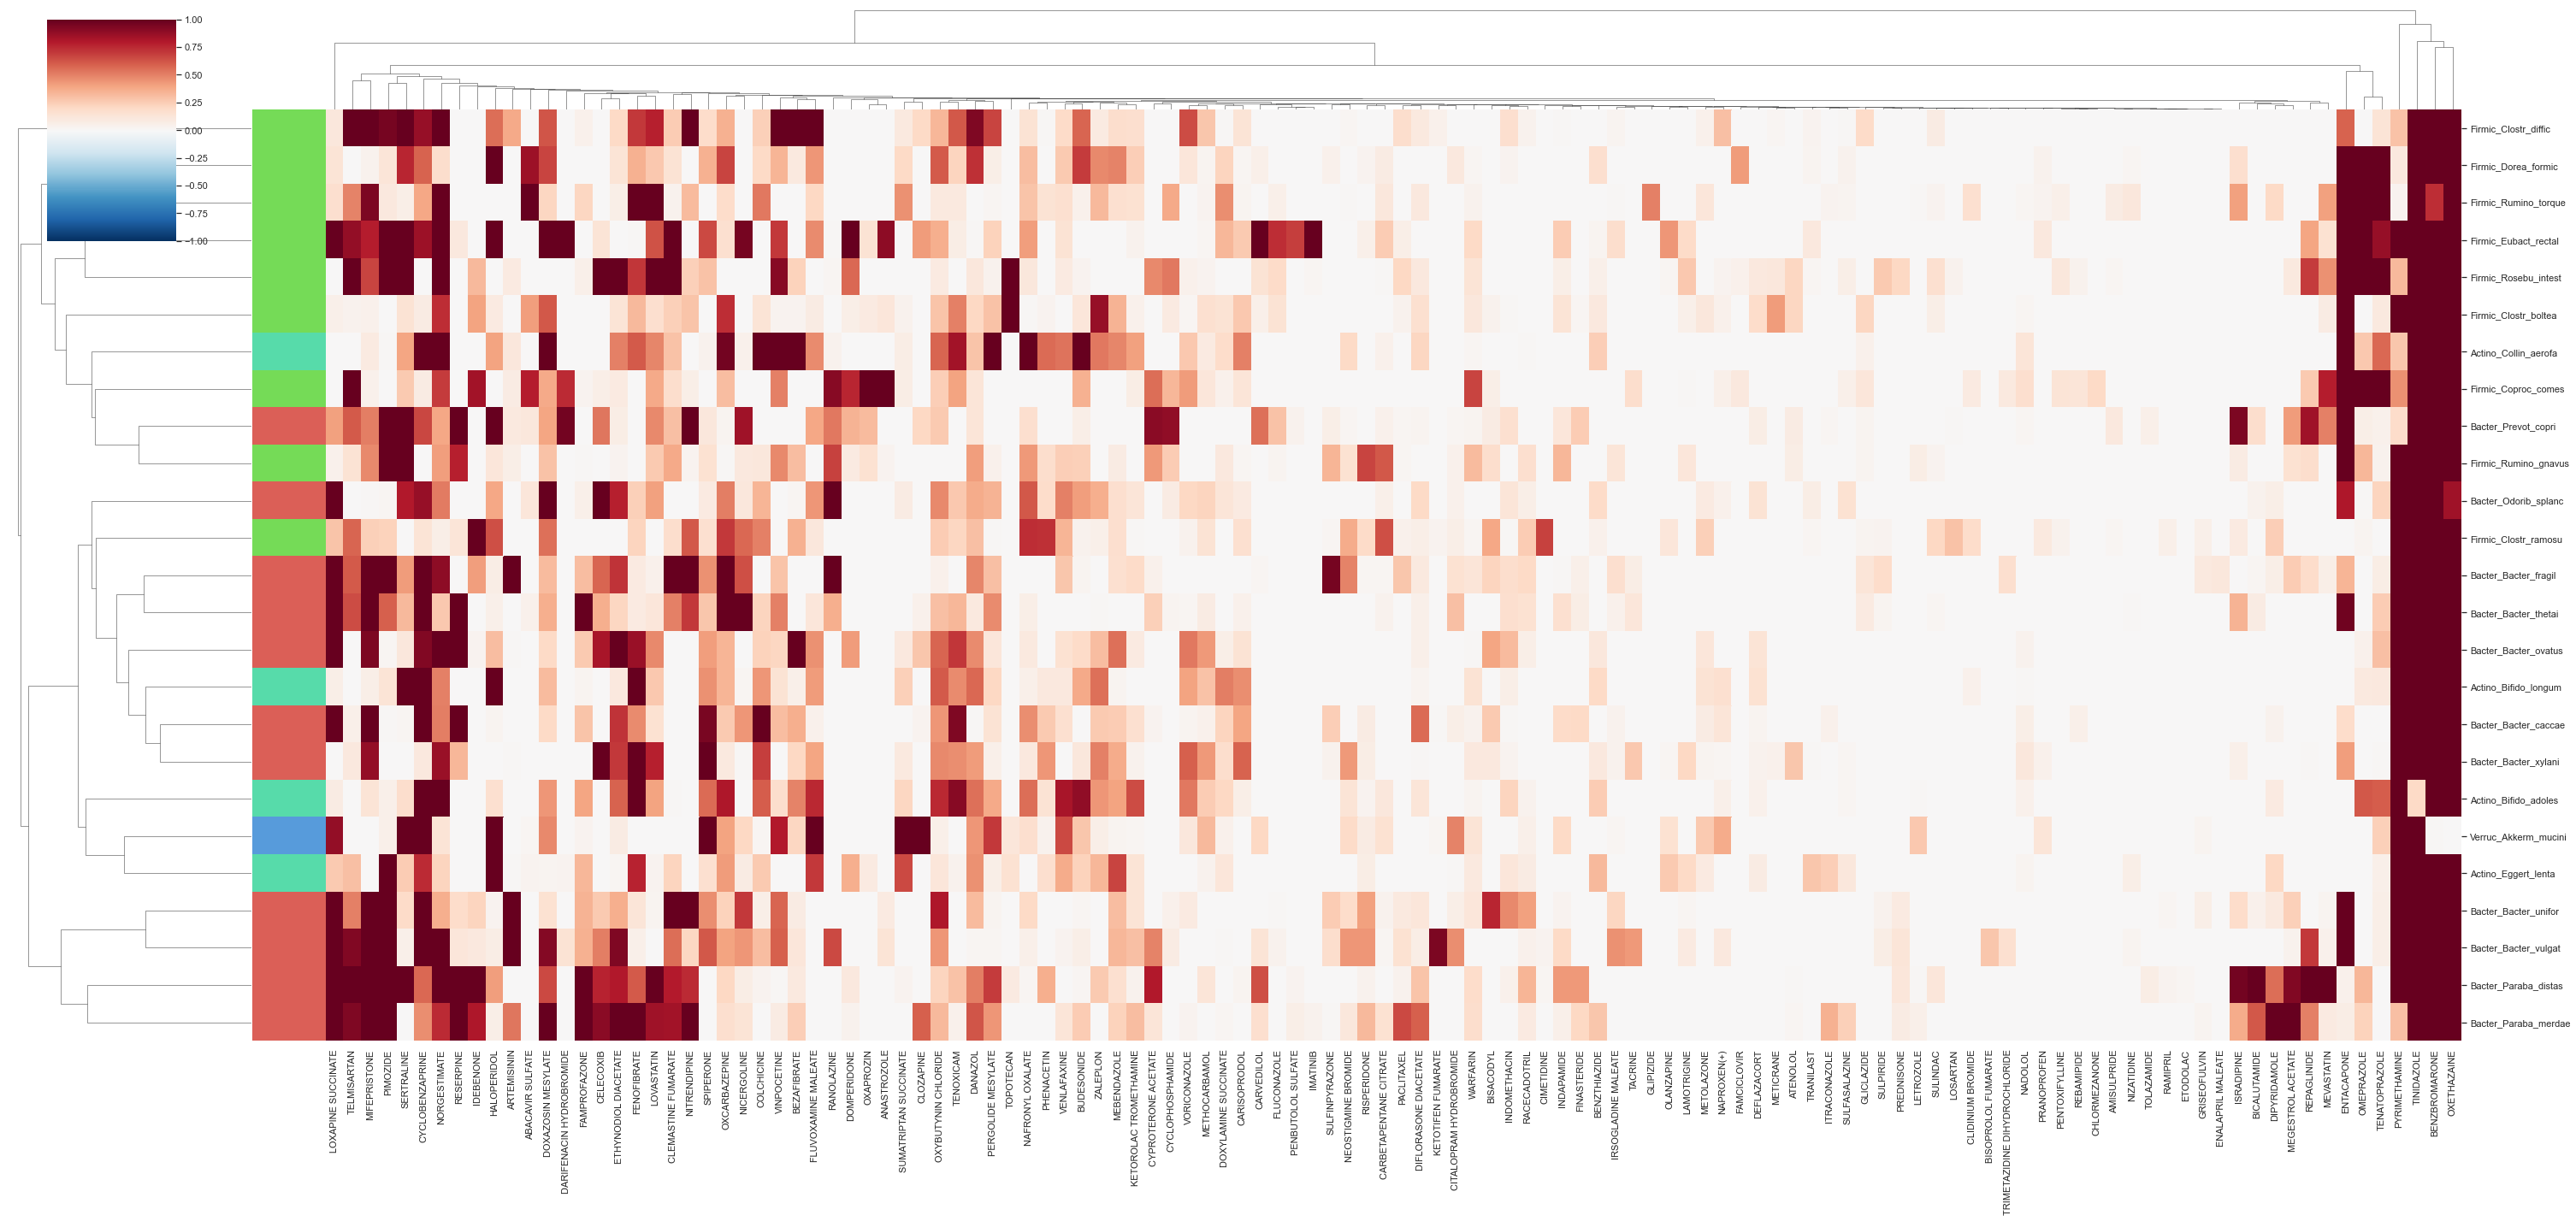

In [52]:
plt.figure()

growth_pval_cmap = sns.clustermap(growth_Pval_ref_study_strains_log, cmap="RdBu_r", center = 0,\
                               row_colors = list(growth_Pval_phyl_list),\
                               vmin = -1, vmax = 1,
                               #col_linkage= g_dist_contr_red.dendrogram_col.linkage,\
                               #row_linkage= g_dist_contr_red.dendrogram_row.linkage,\
                               dendrogram_ratio=0.1,\
                               figsize=(42,20), yticklabels=True,\
                               xticklabels=True, annot_kws={"size": 3})

#plt.savefig('intermed_results/11_filtering_dist_to_cont/'+\
#        today+'_growth_negLog10Pval_cmap.pdf',\
#        bbox_inches='tight')


plt.show()

In [187]:
growth_Pval_ref_study_strains_log.shape

(25, 120)

In [184]:
growth_Pval_bool = growth_Pval_ref_study_strains_log > 1.3

In [185]:
high_impact_drugs = growth_Pval_bool.sum().sort_values(ascending=False)

In [186]:
high_impact_drugs[:30]

TINIDAZOLE                  24
BENZBROMARONE               21
OXETHAZAINE                 20
PYRIMETHAMINE               15
ENTACAPONE                  10
LOXAPINE SUCCINATE           8
PIMOZIDE                     8
MIFEPRISTONE                 7
NORGESTIMATE                 6
CYCLOBENZAPRINE              6
OMEPRAZOLE                   5
RESERPINE                    4
TELMISARTAN                  4
TENATOPRAZOLE                4
SERTRALINE                   4
DOXAZOSIN MESYLATE           3
FENOFIBRATE                  3
HALOPERIDOL                  3
ARTEMISININ                  2
FAMPROFAZONE                 2
CELECOXIB                    2
CLEMASTINE FUMARATE          2
IDEBENONE                    2
ETHYNODIOL DIACETATE         2
SPIPERONE                    2
DARIFENACIN HYDROBROMIDE     1
SUMATRIPTAN SUCCINATE        1
REPAGLINIDE                  1
OXCARBAZEPINE                1
TOPOTECAN                    1
dtype: int64

In [55]:
growth_Pval_ref_study_strains_unlab

TINIDAZOLE  BENZBROMARONE   OXETHAZAINE  PYRIMETHAMINE  ENTACAPONE  \
S054  6.511430e-04       0.965779  1.000000e+00   8.642180e-04    1.000000   
S005  5.038340e-06       0.015110  1.343440e-02   1.861650e-05    0.659620   
S048  2.605180e-05       0.002626  1.041153e-02   4.356230e-05    0.457338   
S065  5.038340e-06       0.001233  1.156917e-02   5.038340e-06    1.000000   
S077  1.428640e-05       0.000323  1.797486e-03   1.744030e-05    0.106586   
S051  1.315840e-06       0.007823  8.061090e-04   5.325670e-04    0.038217   
S016  2.330080e-06       0.002264  1.210380e-05   1.127486e-03    0.006753   
S049  2.062160e-05       0.067694  1.467225e-03   5.514780e-07    0.382252   
S008  6.308312e-01       0.004147  9.199307e-02   5.038340e-06    1.000000   
S046  5.038340e-06       0.057591  1.338190e-05   5.038340e-06    1.000000   
S023  8.232370e-06       0.000082  9.036043e-02   4.374242e-03    0.000007   
S076  5.063860e-06       0.000031  7.629586e-02   5.137176e-01    0.258503   
S007  6.890440e-06       0.000045  2.987860e-05   8.870840e-05    1.000000   
S017  3.198770e-07       0.004132  3.142310e-07   5.257922e-01    0.009153   
S044  8.662560e-06       0.000760  5.038340e-06   3.461375e-01    0.000207   
S033  5.265290e-06       0.018524  1.975430e-05   7.866804e-01    0.000021   
S082  4.103190e-05       0.021454  2.226353e-02   4.328366e-03    1.000000   
S069  9.673280e-04       0.003863  1.666530e-04   2.168721e-03    0.085123   
S060  8.570330e-06       0.000010  1.413695e-01   6.914110e-06    0.154234   
S038  4.865600e-06       0.000005  1.034560e-05   7.477500e-02    0.894442   
S066  4.929710e-07       0.000059  3.272305e-02   5.017709e-01    0.846882   
S041  4.646640e-05       0.002185  6.790140e-05   6.588609e-01    0.029621   
S059  6.048970e-04       0.006441  1.945500e-04   4.751745e-01    0.012478   
S012  5.038340e-06       0.000023  1.165360e-05   7.570777e-02    0.022567   
S047  1.973290e-06       0.183315  6.070660e-06   9.256617e-01    0.000008   

      LOXAPINE SUCCINATE  PIMOZIDE  OMEPRAZOLE  TELMISARTAN  CYCLOBENZAPRINE  \
S054        1.323349e-01  0.867820    1.000000     1.000000         0.001347   
S005        9.326402e-02  0.974608    1.000000     0.867891         0.080397   
S048        2.360803e-02  0.013735    1.000000     0.241735         0.029899   
S065        3.157443e-03  0.961686    0.889879     1.000000         0.118261   
S077        6.129070e-04  0.251410    1.000000     0.224460         0.056079   
S051        4.918900e-05  0.002356    1.000000     0.316193         0.004347   
S016        2.356770e-06  0.001704    1.000000     0.118427         0.005980   
S049        1.000000e+00  1.000000    1.000000     0.783148         0.790284   
S008        8.352546e-01  0.876064    0.239610     1.000000         0.038059   
S046        8.653843e-01  0.735080    0.793318     1.000000         0.101354   
S023        8.735882e-01  1.000000    1.000000     0.907487         0.827580   
S076        7.657636e-01  0.111000    1.000000     0.000016         0.133709   
S007        5.158943e-01  0.583015    0.945027     0.262007         0.734539   
S017        1.000000e+00  0.965695    0.540771     1.000000         0.017138   
S044        1.000000e+00  1.000000    0.018435     0.027280         0.835255   
S033        7.362280e-01  0.743921    0.000013     1.000000         0.258175   
S082        5.485878e-01  0.100398    0.984316     0.502534         0.180636   
S069        6.068250e-02  0.000219    0.006472     0.131258         0.140198   
S060        9.542510e-05  0.960000    0.970445     1.000000         0.135224   
S038        5.038340e-06  0.009098    0.465619     0.004468         0.266490   
S066        4.929710e-07  0.088349    0.586042     0.116134         0.341630   
S041        3.860705e-01  0.004271    0.860768     0.244603         0.213623   
S059        1.000000e+00  0.001273    0.000750     0.011829         1.000000   
S012        8.862672e-01  0.042896    0.461567     0.718156

## Check drug metabolism and growth impact

Text(0, 0.5, 'Drug metabolism [-log2(FC)]')

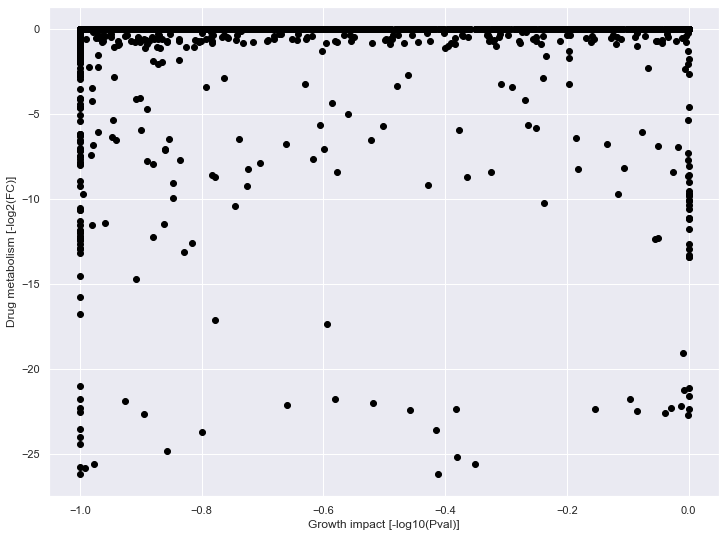

In [61]:
plt.figure(figsize=(12,9))

plt.scatter(-1*growth_Pval_ref_study_strains_unlab.values.flatten(), d_metabo_FC_tab_log_red_maier.values.flatten(),  c='black')

plt.xlabel('Growth impact [-log10(Pval)]')
plt.ylabel('Drug metabolism [-log2(FC)]')

Text(0, 0.5, 'Drug metabolism [% change]')

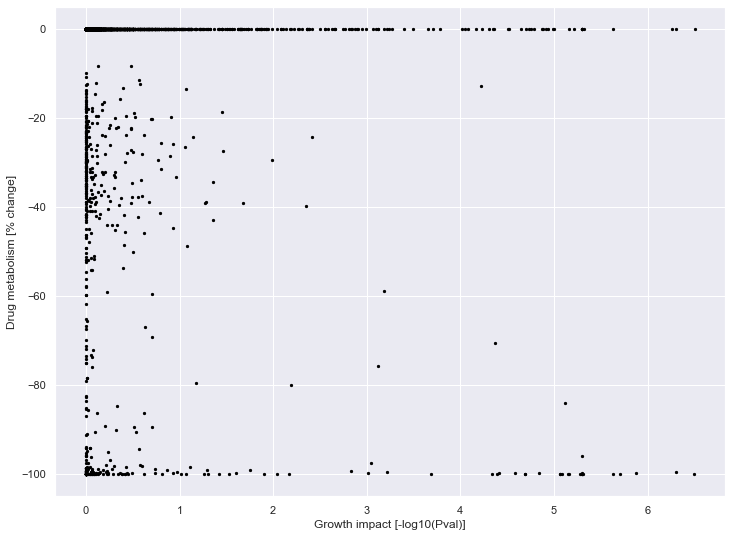

In [66]:
plt.figure(figsize=(12,9))

plt.scatter(-1*np.log10(growth_Pval_ref_study_strains_unlab.values.flatten()), d_metabo_PerC_tab_sig_red_maier.values.flatten(),  c='black', s = 5)

plt.xlabel('Growth impact [-log10(Pval)]')
plt.ylabel('Drug metabolism [% change]')

## Check for enrichment per drug

In [65]:
growth_Pval_ref_study_strains_unlab

TINIDAZOLE  BENZBROMARONE   OXETHAZAINE  PYRIMETHAMINE  ENTACAPONE  \
S054  6.511430e-04       0.965779  1.000000e+00   8.642180e-04    1.000000   
S005  5.038340e-06       0.015110  1.343440e-02   1.861650e-05    0.659620   
S048  2.605180e-05       0.002626  1.041153e-02   4.356230e-05    0.457338   
S065  5.038340e-06       0.001233  1.156917e-02   5.038340e-06    1.000000   
S077  1.428640e-05       0.000323  1.797486e-03   1.744030e-05    0.106586   
S051  1.315840e-06       0.007823  8.061090e-04   5.325670e-04    0.038217   
S016  2.330080e-06       0.002264  1.210380e-05   1.127486e-03    0.006753   
S049  2.062160e-05       0.067694  1.467225e-03   5.514780e-07    0.382252   
S008  6.308312e-01       0.004147  9.199307e-02   5.038340e-06    1.000000   
S046  5.038340e-06       0.057591  1.338190e-05   5.038340e-06    1.000000   
S023  8.232370e-06       0.000082  9.036043e-02   4.374242e-03    0.000007   
S076  5.063860e-06       0.000031  7.629586e-02   5.137176e-01    0.258503   
S007  6.890440e-06       0.000045  2.987860e-05   8.870840e-05    1.000000   
S017  3.198770e-07       0.004132  3.142310e-07   5.257922e-01    0.009153   
S044  8.662560e-06       0.000760  5.038340e-06   3.461375e-01    0.000207   
S033  5.265290e-06       0.018524  1.975430e-05   7.866804e-01    0.000021   
S082  4.103190e-05       0.021454  2.226353e-02   4.328366e-03    1.000000   
S069  9.673280e-04       0.003863  1.666530e-04   2.168721e-03    0.085123   
S060  8.570330e-06       0.000010  1.413695e-01   6.914110e-06    0.154234   
S038  4.865600e-06       0.000005  1.034560e-05   7.477500e-02    0.894442   
S066  4.929710e-07       0.000059  3.272305e-02   5.017709e-01    0.846882   
S041  4.646640e-05       0.002185  6.790140e-05   6.588609e-01    0.029621   
S059  6.048970e-04       0.006441  1.945500e-04   4.751745e-01    0.012478   
S012  5.038340e-06       0.000023  1.165360e-05   7.570777e-02    0.022567   
S047  1.973290e-06       0.183315  6.070660e-06   9.256617e-01    0.000008   

      LOXAPINE SUCCINATE  PIMOZIDE  OMEPRAZOLE  TELMISARTAN  CYCLOBENZAPRINE  \
S054        1.323349e-01  0.867820    1.000000     1.000000         0.001347   
S005        9.326402e-02  0.974608    1.000000     0.867891         0.080397   
S048        2.360803e-02  0.013735    1.000000     0.241735         0.029899   
S065        3.157443e-03  0.961686    0.889879     1.000000         0.118261   
S077        6.129070e-04  0.251410    1.000000     0.224460         0.056079   
S051        4.918900e-05  0.002356    1.000000     0.316193         0.004347   
S016        2.356770e-06  0.001704    1.000000     0.118427         0.005980   
S049        1.000000e+00  1.000000    1.000000     0.783148         0.790284   
S008        8.352546e-01  0.876064    0.239610     1.000000         0.038059   
S046        8.653843e-01  0.735080    0.793318     1.000000         0.101354   
S023        8.735882e-01  1.000000    1.000000     0.907487         0.827580   
S076        7.657636e-01  0.111000    1.000000     0.000016         0.133709   
S007        5.158943e-01  0.583015    0.945027     0.262007         0.734539   
S017        1.000000e+00  0.965695    0.540771     1.000000         0.017138   
S044        1.000000e+00  1.000000    0.018435     0.027280         0.835255   
S033        7.362280e-01  0.743921    0.000013     1.000000         0.258175   
S082        5.485878e-01  0.100398    0.984316     0.502534         0.180636   
S069        6.068250e-02  0.000219    0.006472     0.131258         0.140198   
S060        9.542510e-05  0.960000    0.970445     1.000000         0.135224   
S038        5.038340e-06  0.009098    0.465619     0.004468         0.266490   
S066        4.929710e-07  0.088349    0.586042     0.116134         0.341630   
S041        3.860705e-01  0.004271    0.860768     0.244603         0.213623   
S059        1.000000e+00  0.001273    0.000750     0.011829         1.000000   
S012        8.862672e-01  0.042896    0.461567     0.718156

In [67]:
d_metabo_PerC_tab_sig_red_maier

TINIDAZOLE  BENZBROMARONE  OXETHAZAINE  PYRIMETHAMINE  ENTACAPONE  \
S054  -58.937365            0.0          0.0            0.0  -51.148960   
S005  -99.864614            0.0          0.0            0.0  -99.999978   
S048  -99.878823            0.0          0.0            0.0  -99.999982   
S065  -95.853895            0.0          0.0            0.0  -79.088029   
S077  -99.739327            0.0          0.0            0.0  -99.654370   
S051  -99.879880            0.0          0.0            0.0  -99.999985   
S016  -99.971342            0.0          0.0            0.0  -99.999960   
S049  -99.987267            0.0          0.0            0.0  -99.999982   
S008  -89.202982            0.0          0.0            0.0  -51.795703   
S046  -99.955973            0.0          0.0            0.0  -96.057403   
S023  -99.991015            0.0          0.0            0.0  -99.999968   
S076  -99.890991            0.0          0.0            0.0    0.000000   
S007  -99.984574            0.0          0.0            0.0  -99.999984   
S017  -99.999956            0.0          0.0            0.0  -99.999818   
S044  -99.956696            0.0          0.0            0.0  -99.999985   
S033  -99.999982            0.0          0.0            0.0  -99.911174   
S082  -99.923489            0.0          0.0            0.0  -71.877101   
S069  -99.754230            0.0          0.0            0.0  -99.999983   
S060  -99.990868            0.0          0.0            0.0  -99.999982   
S038  -99.907803            0.0          0.0            0.0  -99.999985   
S066  -99.621095            0.0          0.0            0.0  -99.899013   
S041  -99.989962            0.0          0.0            0.0  -99.999981   
S059  -99.513911            0.0          0.0            0.0  -99.999979   
S012  -99.936012            0.0          0.0            0.0    0.000000   
S047  -99.955370            0.0          0.0            0.0  -84.069963   

      LOXAPINE SUCCINATE   PIMOZIDE  OMEPRAZOLE  TELMISARTAN  CYCLOBENZAPRINE  \
S054                 0.0 -54.235456  -73.520490     0.000000         0.000000   
S005                 0.0   0.000000  -98.589639     0.000000         0.000000   
S048                 0.0   0.000000  -94.226337   -45.874037         0.000000   
S065                 0.0   0.000000  -96.197975   -21.468922         0.000000   
S077                 0.0   0.000000  -95.331559     0.000000         0.000000   
S051                 0.0   0.000000  -95.770336   -50.171141         0.000000   
S016                 0.0   0.000000    0.000000   -44.751271         0.000000   
S049                 0.0   0.000000  -98.894415   -41.907769         0.000000   
S008                 0.0   0.000000  -86.174695     0.000000         0.000000   
S046                 0.0   0.000000  -90.501381     0.000000         0.000000   
S023                 0.0 -32.064318    0.000000     0.000000         0.000000   
S076                 0.0   0.000000  -82.644375     0.000000         0.000000   
S007                 0.0   0.000000  -97.499754     0.000000        -8.292428   
S017                 0.0   0.000000    0.000000     0.000000         0.000000   
S044                 0.0   0.000000    0.000000     0.000000         0.000000   
S033                 0.0   0.000000    0.000000     0.000000         0.000000   
S082                 0.0   0.000000  -78.338348     0.000000         0.000000   
S069                 0.0   0.000000  -79.957701     0.000000         0.000000   
S060                 0.0   0.000000  -78.411073   -24.309209         0.000000   
S038                 0.0   0.000000    0.000000   -39.713098       -12.220132   
S066                 0.0   0.000000  -95.142654     0.000000         0.000000   
S041                 0.0   0.000000  -99.241374     0.000000         0.000000   
S059                 0.0   0.000000  -75.763068     0.000000         0.000000   
S012                 0.0   0.000000  -84.796752     0.000000         0.000000   
S047                 0.0   0.0

In [100]:
drug_enrich_res_df = pd.DataFrame(columns=['G_M', 'NoG_M', 'G_NoM', 'NoG_NoM', 'odds_r','Fisher_Pval'])

In [101]:
# for each drug get contingency table numbers and enrichment score

drugs_to_check = growth_Pval_ref_study_strains_unlab.columns


In [119]:
PerC_thresh = -10
G_Pval_thresh = 0.05

for d in drugs_to_check:
    
    d_G_vals = growth_Pval_ref_study_strains_unlab[d]
    d_M_vals = d_metabo_PerC_tab_sig_red_maier[d]
    
    G_M_count = sum(np.logical_and(d_G_vals < G_Pval_thresh, d_M_vals < PerC_thresh))
    NoG_M_count = sum(np.logical_and(d_G_vals > G_Pval_thresh, d_M_vals < PerC_thresh))
    G_NoM_count = sum(np.logical_and(d_G_vals < G_Pval_thresh, d_M_vals > PerC_thresh))
    NoG_NoM_count = sum(np.logical_and(d_G_vals > G_Pval_thresh, d_M_vals > PerC_thresh))

    cont_tab = pd.DataFrame({'G':[G_M_count, G_NoM_count], 'NoG':[NoG_M_count, NoG_NoM_count]})

    odds_r,Pval = stats.fisher_exact(cont_tab)

    drug_enrich_res_df.loc[d,:]=[G_M_count, NoG_M_count, G_NoM_count, NoG_NoM_count, odds_r,Pval]

In [236]:
G_impact_vec = []

for d in drug_enrich_res_df.index:
    
    G_M_val = drug_enrich_res_df.loc[d, 'G_M']
    G_NoM_val = drug_enrich_res_df.loc[d, 'G_NoM']
    
    if (G_M_val > 3 and G_NoM_val <= 1):
        G_impact_vec.append('Metabolite')
    elif (G_M_val <= 1 and G_NoM_val > 3):
        G_impact_vec.append('Drug')
    
    elif (G_M_val > 1 and G_NoM_val == 0):
        G_impact_vec.append('Metabolite')
    elif (G_M_val == 0 and G_NoM_val > 1):
        G_impact_vec.append('Drug')
        
    elif (G_M_val >= 1 and G_NoM_val >= 1):
        G_impact_vec.append('Mixed')
    else:
        G_impact_vec.append('No growth impact')
        

In [237]:
drug_enrich_res_df['Effector'] = G_impact_vec

In [238]:
main_effector_categories = list(dict(Counter(drug_enrich_res_df['Effector'])))

In [239]:
main_effector_categories = ['Drug', 'Metabolite', 'Mixed', 'No growth impact']

In [240]:
main_effector_values = list(dict(Counter(drug_enrich_res_df['Effector'])).values())

In [241]:
main_effector_values

[2, 14, 8, 96]

In [243]:
main_effector_values = [14, 2, 8, 99]

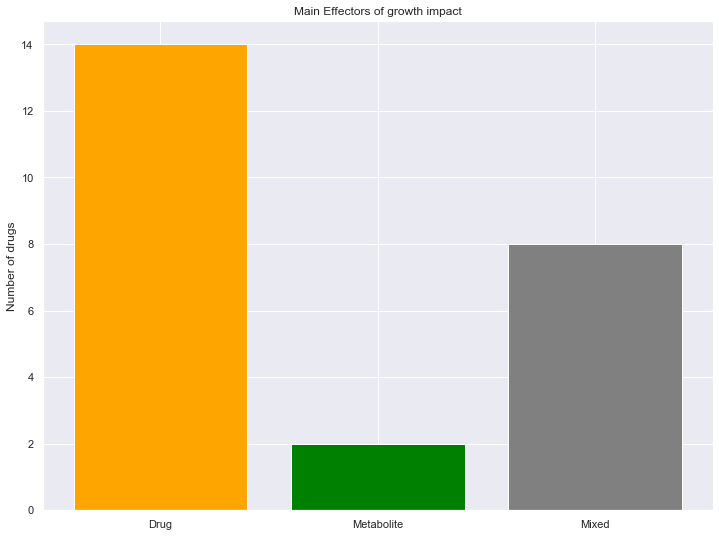

In [244]:
plt.figure(figsize=(12,9))

plt.bar(main_effector_categories[:3],  main_effector_values[:3], color = ['orange', 'green', 'gray'])

plt.title('Main Effectors of growth impact')

plt.ylabel('Number of drugs')


plt.savefig('intermed_results/23_drug_vs_growth/effectors_of_growth_impact.svg', bbox_inches ='tight')

plt.show()

In [247]:
drug_enrich_res_df.loc[drug_enrich_res_df['Effector']=='Drug',:].index

Index(['BENZBROMARONE', 'OXETHAZAINE', 'PYRIMETHAMINE', 'LOXAPINE SUCCINATE',
       'PIMOZIDE', 'CYCLOBENZAPRINE', 'SERTRALINE', 'HALOPERIDOL',
       'NORGESTIMATE', 'SPIPERONE', 'DOXAZOSIN MESYLATE', 'CELECOXIB',
       'FENOFIBRATE', 'ETHYNODIOL DIACETATE'],
      dtype='object')

In [190]:
drug_enrich_res_df['n_Gowth'] = drug_enrich_res_df['G_M']+drug_enrich_res_df['G_NoM']

In [194]:
sum(drug_enrich_res_df['n_Gowth'] > 1)

24

In [242]:
drug_enrich_res_df[:100]

G_M NoG_M G_NoM NoG_NoM    odds_r Fisher_Pval  \
TINIDAZOLE                24     1     0       0       NaN           1   
BENZBROMARONE              0     0    21       4       NaN           1   
OXETHAZAINE                0     0    20       5       NaN           1   
PYRIMETHAMINE              0     0    15      10       NaN           1   
ENTACAPONE                 9    14     1       1  0.642857           1   
LOXAPINE SUCCINATE         0     0     8      17       NaN           1   
PIMOZIDE                   0     2     8      15         0           1   
OMEPRAZOLE                 3    16     2       4     0.375    0.562281   
TELMISARTAN                1     6     3      15  0.833333           1   
CYCLOBENZAPRINE            0     1     6      18         0           1   
TENATOPRAZOLE              3    19     1       2  0.315789    0.421739   
SERTRALINE                 0     0     4      21       NaN           1   
IDEBENONE                  1     8     1      15     1.875           1   
MIFEPRISTONE               3     2     4      16         6    0.113043   
HALOPERIDOL                0     0     2      23       NaN           1   
ARTEMISININ                1    24     0       0       NaN           1   
ABACAVIR SULFATE           0     0     1      24       NaN           1   
OXAPROZIN                  0     8     1      16         0           1   
CARVEDILOL                 0     0     0      25       NaN           1   
SUMATRIPTAN SUCCINATE      0     1     1      23         0           1   
NORGESTIMATE               0     3     6      16         0    0.553913   
DARIFENACIN HYDROBROMIDE   0     0     1      24       NaN           1   
PACLITAXEL                 0     5     0      20       NaN           1   
SPIPERONE                  0     0     2      23       NaN           1   
FAMPROFAZONE               1     8     1      15     1.875           1   
DOXAZOSIN MESYLATE         0     0     3      22       NaN           1   
RESERPINE                  1     3     3      18         2    0.526877   
ITRACONAZOLE               0     3     0      19       NaN           1   
FLUCONAZOLE                0     0     0      25       NaN           1   
VORICONAZOLE               0     6     0      19       NaN           1   
GRISEOFULVIN               0     6     0      19       NaN           1   
MEBENDAZOLE                0     7     0      18       NaN           1   
FAMCICLOVIR                0    11     0      14       NaN           1   
ISRADIPINE                 0     0     0      25       NaN           1   
LETROZOLE                  0     1     0      24       NaN           1   
RISPERIDONE                0    10     0      15       NaN           1   
PENBUTOLOL SULFATE         0     2     0      23       NaN           1   
REPAGLINIDE                0     4     1      20         0           1   
DANAZOL                    0    23     0       2       NaN           1   
CYPROTERONE ACETATE        0     8     0      17       NaN           1   
RANOLAZINE                 0     0     0      25       NaN           1   
METICRANE                  0     0     0      25       NaN           1   
RAMIPRIL                   0     3     0      22       NaN           1   
METOLAZONE                 0     0     0      25       NaN           1   
OXCARBAZEPINE              0     0     1      24       NaN           1   
REBAMIPIDE                 0     0     0      25       NaN           1   
VENLAFAXINE                0     0     0      25       NaN           1   
IRSOGLADINE MALEATE        0     0     0      25       NaN           1   
TOPOTECAN                  0     0     1      24       NaN           1   
TRANILAST                  0     0     0      25       NaN           1   
AMISULPRIDE                0     0     0      25       NaN           1   
ANASTROZOLE                0     1     1      23         0           1   
BICALUTAMIDE               0     0     1      24       NaN           1   
IMATINIB                   0 